# Intro
<font color=blue> In this notebook, I have introduced a simple image denoising method based on convolutional neural networks (CNN) and deep learning. During this method, I have also introduced an approach to create and use dataset based on hdf format.<br>
Before starting to read the method, I ask you to consider some points related to this implementation:<br></font>
1. The model was designed by keras api and in python language.
2. The model is a simple model which can be test by cpu.
3. I used generators to train my model.
4. The input images in this model was 256x256. The images were in grayscale color space.
5. The original data which the model was trained and validate by, was so large. Hence it wasn't rational to upload the data.  But I tried to show some example images and also describe the structure of saved data.<br>

# Importing packages and modules

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow.keras.callbacks as tkc
from tensorflow.keras import optimizers
import matplotlib.pyplot as plt
from tensorflow.keras import models
import h5py
from scipy.ndimage import gaussian_filter as gf

# Create and manage dataset
For designing Denoising model, we need image dataset. For this purpose, I used **[Caltech 101 dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/)**.<br>
I chose some images from this dataset randomly with one condition: _The shape of the image must be bigger than 256x256_ , so I could extract a random patch from this image.<br>
After that, I categorized chosen images into three categories:<br>
1-Train <br>
2- Validation <br>
3- Test <br>
I managed the dataset in hdf5 format(Creating three different datasets in one file).<br>
## structure of dataset
Here is the method of creating dataset: <br>
I added Gaussian noise to each image, then saved original image as **Label**, and noisy image as **Inputs**. I repeated this procedure for each image.<br>
**Note** <br>
- **For producing Gaussian noise, we need to choose sigma (or variance) for Gaussian distribution. For more flexibility of the model, I chose this noise randomly for each image between [.1,.2] interval. Of course this interval can be changed, based on the problem.**  <br> 
- **Both original images and noisy images were scaled between [0,1].** <br>
I saved the result in an HDF file named 'Data.hdf', which is loaded in the below cell. You can also see the internal structure of the file.<br>


In [3]:
f=h5py.File('Data.hdf','r')
f.visit(lambda x: print (x))

Test
Test/Inputs
Test/Labels
Train
Train/Inputs
Train/Labels
Val
Val/Inputs
Val/Labels


# Number of data
Here is the number of data in each category.

In [14]:
print ('Number of train data : {}'.format (len(f['/Train/Inputs'])))
print ('Number of validation data : {}'.format (len(f['/Val/Inputs'])))
print ('Number of test data : {}'.format (len(f['/Test/Inputs'])))

Number of train data : 1413
Number of validation data : 143
Number of test data : 82


# Some samples of dataset
In the below cells, you can see some examples of training data and their labels respectively. Note that all the images are 256x256.

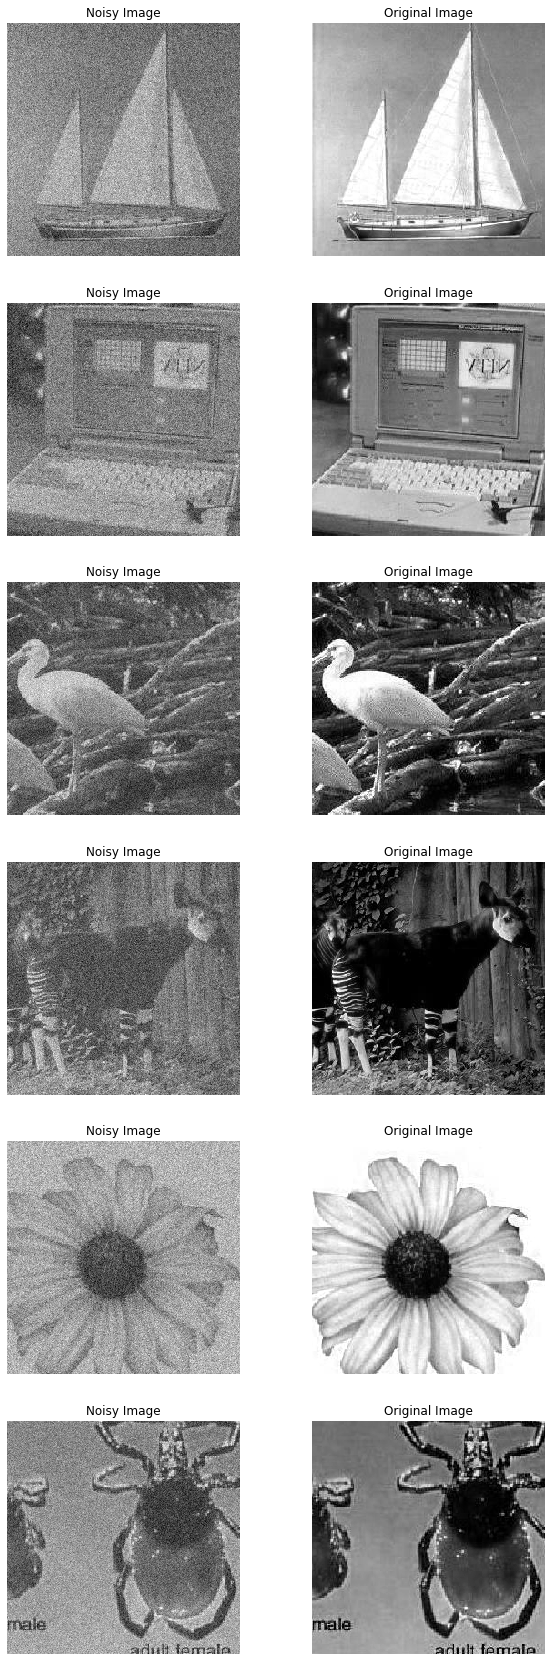

In [11]:
fig , ax = plt.subplots(6,2,figsize=(10,30))
for i in range(6):
    c=np.random.randint(len(f['/Train/Inputs']))
    ax[i,0].imshow(f['/Train/Inputs'][c,:,:,0],cmap='gray'),ax[i,0].axis('off') , ax[i,0].set_title('Noisy Image')
    ax[i,1].imshow(f['/Train/Labels'][c,:,:,0],cmap='gray'),ax[i,1].axis('off') , ax[i,1].set_title('Original Image')

# Set parameters
Now, let's turn to more machine learning task!<br>
First I set some parameters for furthur usage.

In [16]:
batch_size     = 32
nb_ephochs     = 50
input_shape    = (256,256,1)

# Network structure
For designing Denoising network, I chose convolutional neural network. I chose a simple model which comprised of 3 conv layers and 2 deconv layers. Here are some important notes in designing this network: <br>
**Notes**<br>
- I didn't use maxpooling layers in this structure, because using maxpooling, needs some upsampling methods to create output same size of input. And because of few number of training, I decided to not use both pooling and upsampling layers. Of course these layers can be used in more complex networks (and even achieve better results).<br>
- Unfortunately I didn't have a powerful processor or gpu. So I had to design simple model which could be run on cpu fast.
- Size of filters are all set to 3. This number inferred by trial and error. However, the filter size of 3 is a common choice in designing CNNs.<br>
- I didn't use dropout layers, because I think that Denoising problem has some dropout characteristics in itself. So I didn't use it.
- In the last layer, I constrained the output of layer to maximum of 1. This is due to fact that the original images are scaled between [0,1]. So the desired value of every pixel is between [0,1] obviously. This will be help to get better results.

In [17]:
model = Sequential()
model.add(layers.Conv2D(5,kernel_size=3,padding='same',activation='relu',input_shape=input_shape))
model.add(layers.Conv2D(10,kernel_size=3,padding='same',activation='relu'))

model.add(layers.Conv2DTranspose(10,kernel_size=3,activation='relu',padding='same'))
model.add(layers.Conv2DTranspose(10,kernel_size=3,activation='relu',padding='same'))

model.add(layers.Conv2D(1,kernel_size=3,padding='same'))
model.add(layers.ReLU(max_value=1))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 256, 256, 5)       50        
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 256, 256, 10)      460       
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 256, 256, 10)      910       
_________________________________________________________________
conv2d_transpose_3 (Conv2DTr (None, 256, 256, 10)      910       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 256, 256, 1)       91        
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256, 256, 1)       0         
Total params: 2,421
Trainable params: 2,421
Non-trainable params: 0
____________________________________________________

# Optimzer, Loss and Callbacks
I used adam optimizer with learning rate of 0.01 which was decreased on loss function plateau. I used mse as a loss function because the problem is to Denoising and we wanted to make same input and output. For accuracy metric, I chose mae, because the value of pixels are between [0,1], and mae From a perspective shows the precent of error in each pixel (I know it is a weak reason, however I think mae is more informative than mse for accuracy!) <br>
To control the training procedure, I defined some callbacks: <br>
1. Model check point: to save the best model during training process.
2. Reduce on plateau: to reduce the learning rate when the loss function get stuck.

In [18]:
opt=optimizers.Adam(learning_rate=0.01)
mc=tkc.ModelCheckpoint('model.hdf5',save_best_only=True)
rop=tkc.ReduceLROnPlateau(factor=0.5,patience=3,min_lr=0.00001,min_delta=0.01,verbose=1)

# Data generator
Because of my weak system and low RAM and big size of data, I decided to use generator techniques to train my network. For this purpose I had to design a generator function which each time bring a batch of data to memory for train. The function below does the explained task. The function takes an HDF group and batch size as inputs and yields batches of training data and labels in a decent manner. <br>

In [19]:
def data_prep(f,batch_size):
    while True:
        for i in range(0,f['Inputs'].shape[0],batch_size):
            p=np.random.permutation(f['Inputs'].shape[0])
            selected_p=p[:batch_size]
            selected_p.sort()
            yield f['Inputs'][selected_p[:batch_size],:],f['Labels'][selected_p[:batch_size],:]

Next I defined two generator functions to use in fit_generator model method. One function belongs to train and the other belongs to validation data.

In [20]:
train_generator=data_prep(f['/Train'],batch_size)
val_generator=data_prep(f['/Val'],batch_size)

# Compile and train network

In [21]:
model.compile(optimizer=opt,loss='mse',metrics=['mae'])
num_train_data=f['/Train/Inputs'].shape[0]
model.fit_generator(train_generator,
                    steps_per_epoch=np.floor(num_train_data/batch_size),
                    epochs=nb_ephochs,
                    verbose=1,validation_data=val_generator,validation_steps=1,callbacks=[mc,rop])


Epoch 1/50
44/44 [==============================] - 321s 7s/step - loss: 0.0790 - mae: 0.2101 - val_loss: 0.0218 - val_mae: 0.1111
Epoch 2/50
44/44 [==============================] - 282s 6s/step - loss: 0.0229 - mae: 0.1119 - val_loss: 0.0166 - val_mae: 0.0966
Epoch 3/50
44/44 [==============================] - 337s 8s/step - loss: 0.0213 - mae: 0.1070 - val_loss: 0.0152 - val_mae: 0.0924
Epoch 4/50
43/44 [============================>.] - ETA: 6s - loss: 0.0196 - mae: 0.1016 
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
44/44 [==============================] - 272s 6s/step - loss: 0.0197 - mae: 0.1018 - val_loss: 0.0176 - val_mae: 0.0966
Epoch 5/50
44/44 [==============================] - 270s 6s/step - loss: 0.0187 - mae: 0.1007 - val_loss: 0.0158 - val_mae: 0.0936
Epoch 6/50
44/44 [==============================] - 252s 6s/step - loss: 0.0173 - mae: 0.0967 - val_loss: 0.0123 - val_mae: 0.0836
Epoch 7/50
43/44 [============================>.] - ETA:

# Evaluate the results
Now it's time to check and evaluate the output of model. For this purpose, I decided to also compare the result with a Gaussian filter. So in next cell, I chose a test image, add Gaussian noise to it and applied both techniques (my model and Gaussian filter) on it. You can find the results below.<br>
**You can test your own images with little changes on below code! (Just change the file path to your desired image)** <br>
****Note**** <br>
**The train data was generated by Gaussian noise with variance between [.1,.2]. Although you can add Gaussian noise with any variance to your desired image, the best result will be produce on the noise with same variance.**

In [22]:
model=models.load_model('model.hdf5')

(<matplotlib.image.AxesImage at 0x21721c62788>,
 (-0.5, 255.5, 255.5, -0.5),
 Text(0.5, 1.0, 'Gaussian filter_result'))

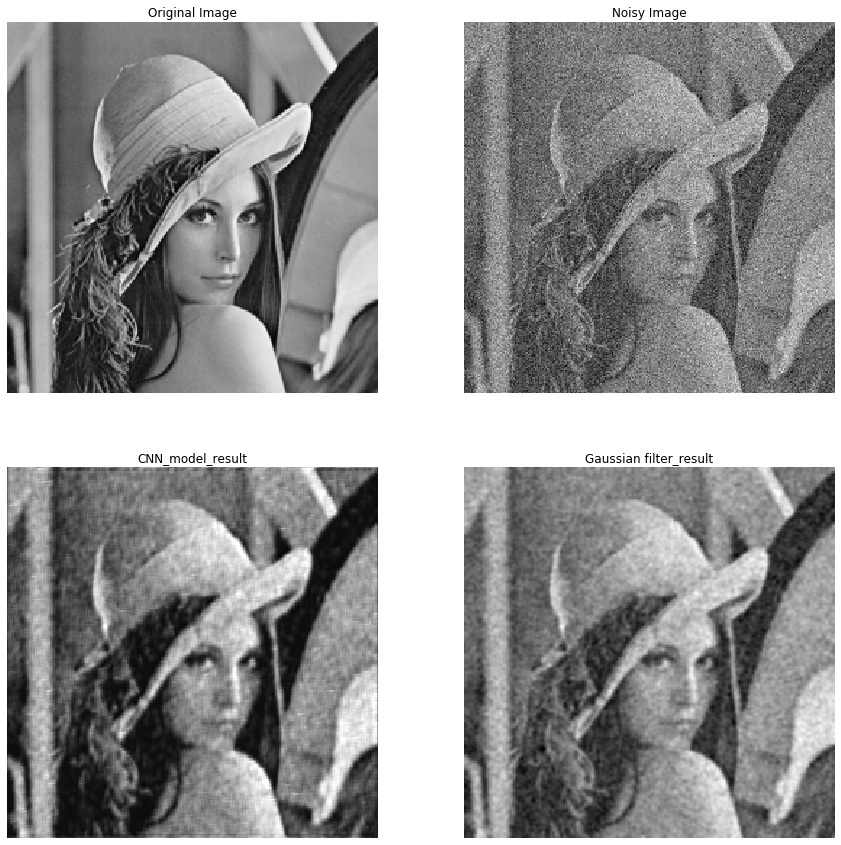

In [68]:
Original_image=plt.imread('test.jpg')

# Convert RGB image to grayscale image
Original_image=np.mean(Original_image,axis=2)
x_start=np.random.randint(0,Original_image.shape[0]-256)
y_start=np.random.randint(0,Original_image.shape[1]-256)
patch=Original_image[x_start:x_start+256,y_start:y_start+256]
patch=patch/255
sigma=np.random.uniform(.1,.2)

noise=np.random.normal(scale=sigma,size=(256,256))
sample=noise+patch
sample=(sample-np.min(sample))/(np.max(sample)-np.min(sample))

sample=np.expand_dims(sample,axis=0)
sample=np.expand_dims(sample,axis=3)
CNN_result=model.predict(sample)
Gaussian_filter_result = gf(sample[0,:,:,0], sigma=1)

fig, ax = plt.subplots(2,2,figsize=(15,15))
ax[0,0].imshow(patch,cmap='gray'), ax[0,0].axis('off') , ax[0,0].set_title('Original Image')
ax[0,1].imshow(sample[0,:,:,0],cmap='gray'), ax[0,1].axis('off') , ax[0,1].set_title('Noisy Image')
ax[1,0].imshow(CNN_result[0,:,:,0],cmap='gray'), ax[1,0].axis('off') , ax[1,0].set_title('CNN_model_result')
ax[1,1].imshow(Gaussian_filter_result,cmap='gray'), ax[1,1].axis('off') , ax[1,1].set_title('Gaussian filter_result')

By Watching the results it can be inferred that the CNN_model perform better than Gaussian_filtering methods, particularly on the edges of objects in image.